Import all libray

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report



Prepare the data training

In [97]:
data = pd.read_csv("extracted_features.csv")

# Extract features and labels
X = data.iloc[:, :-1].values  # Features (all columns except the last one)
y = data.iloc[:, -1].values   # Class labels (the last column)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode class labels if they are categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Create sequences from the data
sequence_length = 10  # You can choose an appropriate sequence length
num_features = X.shape[1]

# Create sequences and labels
sequences = []
labels = []
for i in range(len(X) - sequence_length + 1):
    sequences.append(X[i:i + sequence_length])
    labels.append(y[i + sequence_length - 1])

X_sequences = np.array(sequences)
y_labels = np.array(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_labels, test_size=0.2, random_state=42)

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


Run the Model

In [98]:
model = Sequential()

# Input layer
model.add(LSTM(units=32, input_shape=(sequence_length, num_features), activation='relu', return_sequences=True))

# Dropout layer for regularization
model.add(Dropout(0.6))

# Second hidden layer
model.add(LSTM(units=16, activation='relu'))

# Output layer
model.add(Dense(units=np.max(y_labels) + 1, activation='softmax'))

# Compile the model with accuracy metric
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto', min_delta=0.01)


# ... (previous code)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Learning rate schedule callback
def lr_schedule(epoch):
    if epoch < 50:
        return 0.001
    elif 50 <= epoch < 100:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with validation data and callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint, lr_scheduler])

# ... (rest of the code)


# Train the model with validation data and callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Display the validation accuracy history
# print("Validation Accuracy History:", history.history['val_accuracy'])

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/200
32/33 [============================>.] - ETA: 0s - loss: 1.9705 - accuracy: 0.2266
Epoch 1: val_accuracy improved from -inf to 0.29565, saving model to best_model.h5
33/33 [==============================] - 5s 24ms/step - loss: 1.9703 - accuracy: 0.2255 - val_loss: 1.8037 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 2/200
20/33 [=================>............] - ETA: 0s - loss: 1.6759 - accuracy: 0.3609

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/33 [============================>.] - ETA: 0s - loss: 1.5766 - accuracy: 0.4053
Epoch 2: val_accuracy improved from 0.29565 to 0.52174, saving model to best_model.h5
33/33 [==============================] - 0s 12ms/step - loss: 1.5769 - accuracy: 0.4043 - val_loss: 1.3082 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 3/200
30/33 [==========================>...] - ETA: 0s - loss: 1.1884 - accuracy: 0.5854
Epoch 3: val_accuracy improved from 0.52174 to 0.64348, saving model to best_model.h5
33/33 [==============================] - 0s 12ms/step - loss: 1.1653 - accuracy: 0.5957 - val_loss: 1.0168 - val_accuracy: 0.6435 - lr: 0.0010
Epoch 4/200
27/33 [=======================>......] - ETA: 0s - loss: 0.9089 - accuracy: 0.6748
Epoch 4: val_accuracy improved from 0.64348 to 0.66957, saving model to best_model.h5
33/33 [==============================] - 0s 11ms/step - loss: 0.9074 - accuracy: 0.6754 - val_loss: 0.8983 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 5/200
33/33 [=====================

Show The trained model Confusion Matrix

9/9 [==============================] - 0s 4ms/step


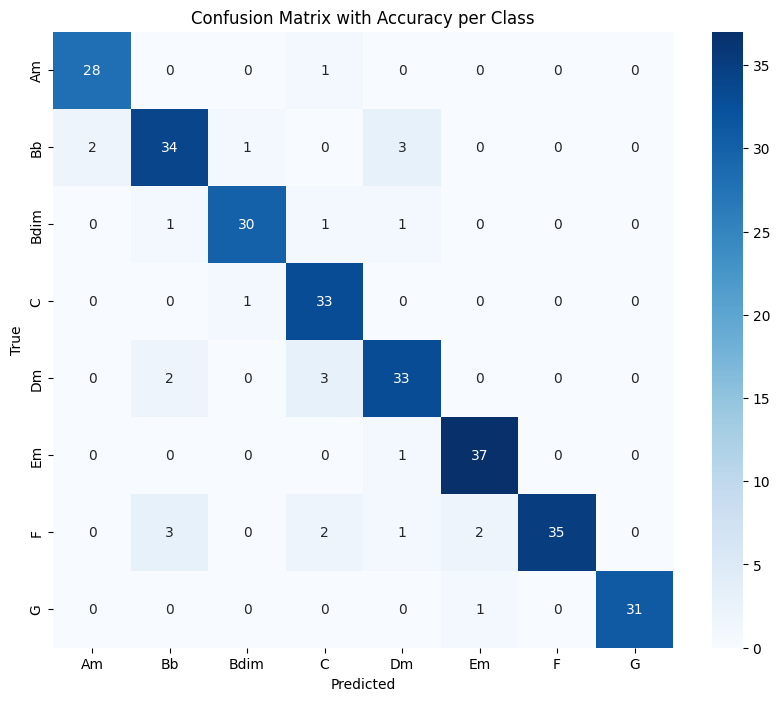

Classification Report:
              precision    recall  f1-score   support

          Am       0.93      0.97      0.95        29
          Bb       0.85      0.85      0.85        40
        Bdim       0.94      0.91      0.92        33
           C       0.82      0.97      0.89        34
          Dm       0.85      0.87      0.86        38
          Em       0.93      0.97      0.95        38
           F       1.00      0.81      0.90        43
           G       1.00      0.97      0.98        32

    accuracy                           0.91       287
   macro avg       0.91      0.92      0.91       287
weighted avg       0.91      0.91      0.91       287



In [99]:
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded format to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true class labels to a flat array
y_true = y_test

# Create a confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

# Calculate accuracy per class
class_accuracy = confusion.diagonal() / confusion.sum(axis=1)

# Plot the confusion matrix with accuracy annotations
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Accuracy per Class')
plt.show()

report = classification_report(y_true, y_pred_labels, target_names=label_encoder.classes_)

# Print the classification report to the terminal
print("Classification Report:")
print(report)




Testing model using testing data

Prepare the testing data

10/10 [==============================] - 0s 4ms/step - loss: 16.2898 - accuracy: 0.1801
New Test Loss: 16.2898, New Test Accuracy: 0.1801
10/10 [==============================] - 0s 4ms/step


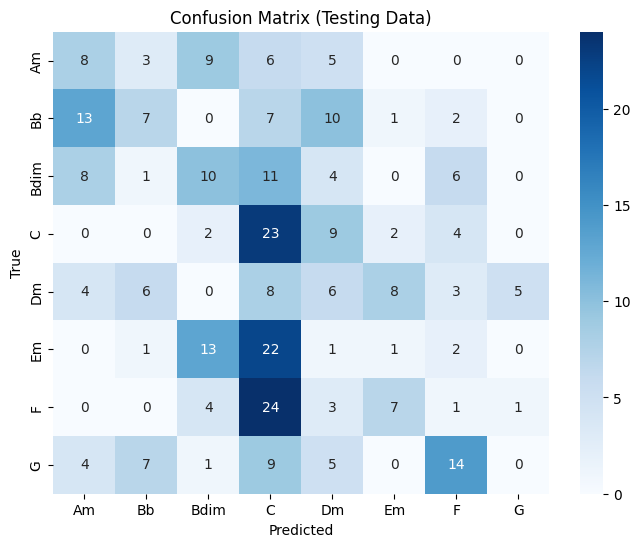

In [100]:
data = pd.read_csv("Testing_Data.csv")

# Extract features and labels
X = data.iloc[:, :-1].values  # Features (all columns except the last one)
y = data.iloc[:, -1].values   # Class labels (the last column)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode class labels if they are categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Create sequences from the data
sequence_length = 10  # You can choose an appropriate sequence length
num_features = X.shape[1]

# Create sequences and labels
sequences = []
labels = []
for i in range(len(X) - sequence_length + 1):
    sequences.append(X[i:i + sequence_length])
    labels.append(y[i + sequence_length - 1])

X_sequences = np.array(sequences)
y_labels = np.array(labels)

# Evaluate the model on the testing data
test_loss_new, test_accuracy_new = model.evaluate(X_sequences, y_labels)

print(f"New Test Loss: {test_loss_new:.4f}, New Test Accuracy: {test_accuracy_new:.4f}")

# Make predictions on the testing data
y_pred_new = model.predict(X_sequences)

# Convert predictions from one-hot encoded format to class labels
y_pred_labels_new = np.argmax(y_pred_new, axis=1)

# Create a confusion matrix for the testing data
confusion_new = confusion_matrix(y_labels, y_pred_labels_new)

# Plot the confusion matrix for the testing data
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_new, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Testing Data)')
plt.show()

Test the model using testing data

Show the confusion matrix of testing data

In [101]:
confusion_new = confusion_matrix(y_true_new, y_pred_labels_new)

# Plot the confusion matrix for the new testing data
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_new, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - New Testing Data')
plt.show()

# Evaluate the performance on the new testing data
test_loss_new, test_accuracy_new = model.evaluate(X_test_new, y_test_new_encoded)
print(f"New Test Loss: {test_loss_new:.4f}, New Test Accuracy: {test_accuracy_new:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [320, 311]

In [ ]:
precision = precision_score(y_labels_test, y_pred_labels_test, average='weighted', zero_division=1)
recall = recall_score(y_labels_test, y_pred_labels_test, average='weighted', zero_division=1)
f1 = f1_score(y_labels_test, y_pred_labels_test, average='weighted', zero_division=1)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

NameError: name 'y_labels_test' is not defined